# Real wave number

In [1]:
using Plots, SparseArrays, LinearAlgebra, Krylov, Revise
includet("nonuniformMultiGrid.jl")
includet("constructions2D.jl")
includet("grid_constructions1D.jl")
includet("grid_constructions2D.jl")
includet("linespacecs.jl")
includet("MG_preconditioner.jl")

In [2]:
n = 2^7
grid,m = linspacecs(0,1,n+1,pi/6)
f =zeros(length(grid),length(grid))
f[:,64] .= n
f = vec(f);
σ = -10000* ones(length(grid),length(grid))
σ[:, 126:130] .= -1000000
σ[union(106:110, 146:150), 126:130] .= -10000
sigmas = spdiagm(vec(σ))
H = helmholtz2D(grid,sigmas);

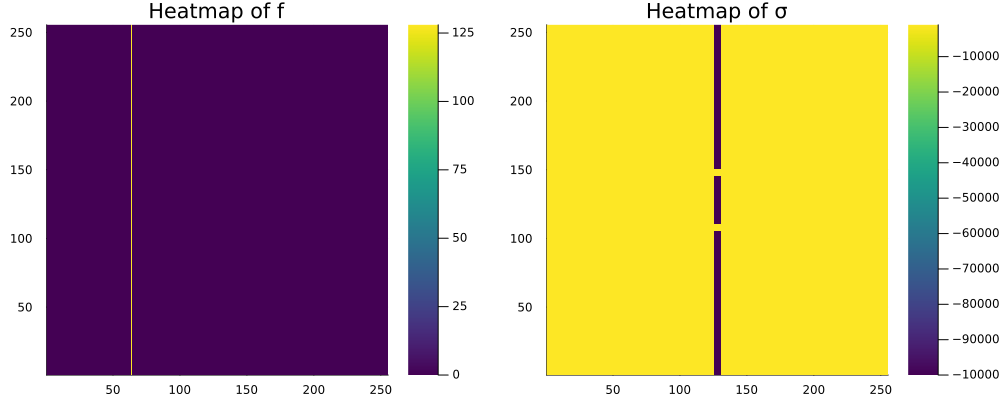

In [3]:
p1 = heatmap(reshape(f,length(grid),length(grid)), color=:viridis, title="Heatmap of f")
p2 = heatmap(reshape(σ,length(grid),length(grid)), color=:viridis, title="Heatmap of σ")

plot(p1, p2, layout = (1, 2), size = (1000, 400))

In [4]:
sol = H\f;

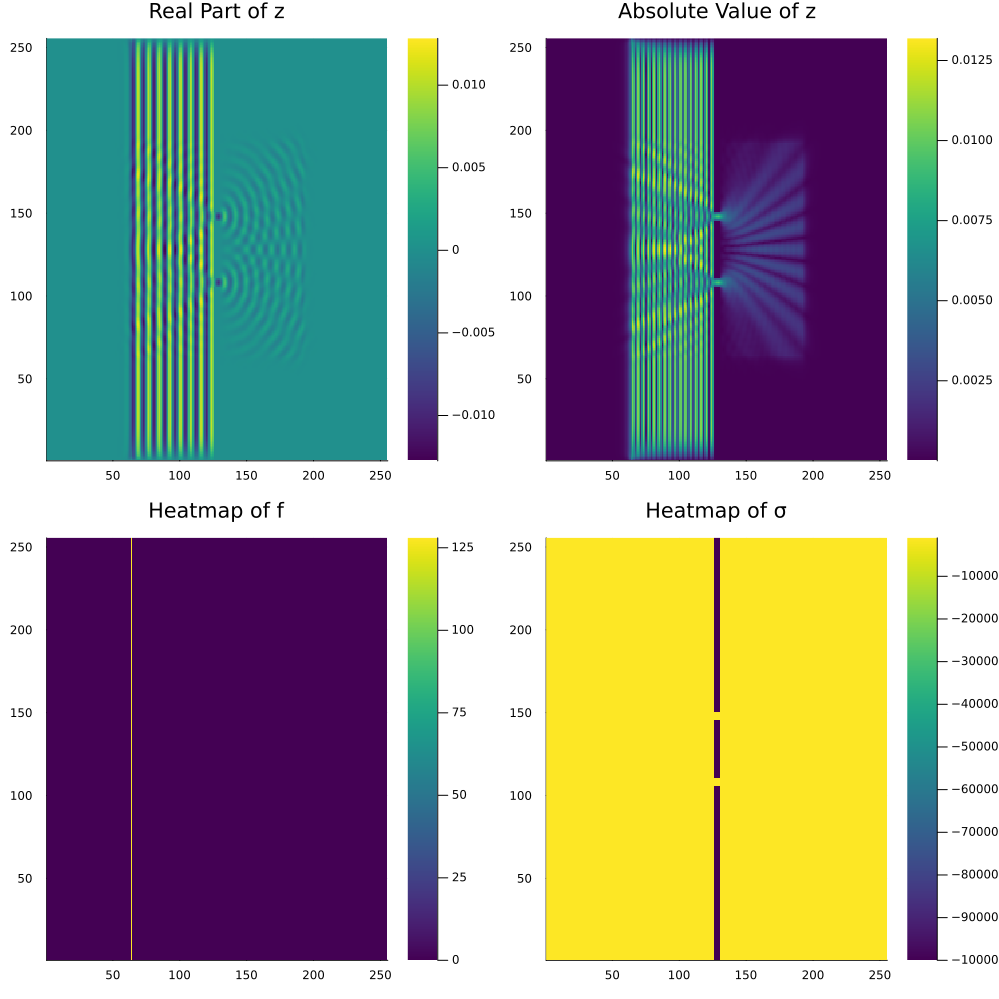

In [5]:
theme(:default)
z = reshape(sol, 2n-1, 2n-1)
p1 = heatmap(real(z), color=:viridis, title="Real Part of z")
p2 = heatmap(abs.(z), color=:viridis, title="Absolute Value of z")
p3 = heatmap(reshape(f,length(grid),length(grid)), color=:viridis, title="Heatmap of f")
p4 = heatmap(reshape(σ,length(grid),length(grid)), color=:viridis, title="Heatmap of σ")

plot(p1, p2, p3, p4, layout = (2, 2), size = (1000, 1000))


In [6]:
u = zeros(length(f))
errors = Float64[]

for _ in 1:20
    u = nonUniformVcycle2D(
        grid=grid,
        A=H,
        f=f,
        u=u,
        nu1=1,
        nu2=1,
        recursion_depth=50)
    error = norm(sol - u)
    push!(errors, error)
end

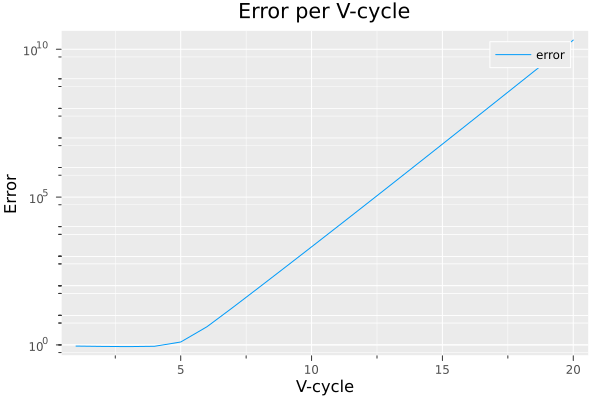

In [7]:
theme(:ggplot2)
plot(errors, title="Error per V-cycle", label="error", xlabel="V-cycle", ylabel="Error",yscale=:log10)

Eigenvectors aren't easy to derive anymore, still need to find good explainer. Well we don't expect convergence without a wall and the wall acts like boundary conditions...

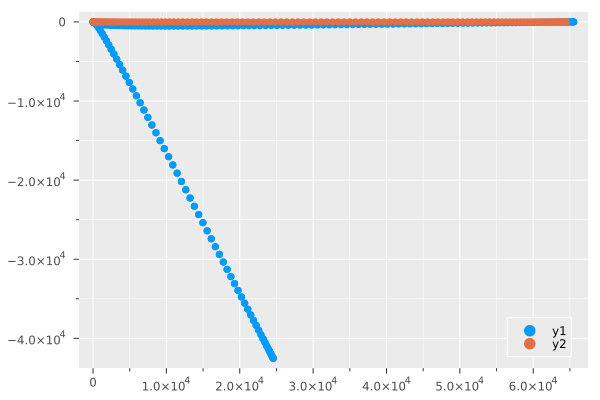

In [8]:
P = Poisson1D(grid)
Pr = Poisson1D(range(0,1,128))
eigenvalues = eigvals(Matrix(P))
scatter(real(eigenvalues),imag(eigenvalues))
eigenvalues = eigvals(Matrix(Pr))
scatter!(real(eigenvalues),imag(eigenvalues))

# Complex wave number

In [9]:
n = 2^7
grid,m = linspacecs(0,1,n+1,pi/6)
f =zeros(length(grid),length(grid))
f[:,64] .= n
f = vec(f);
complex_shift = (1+1*im)
σ = -10000 * ones(length(grid),length(grid))
σ[:, 126:130] .= -1000000
σ[union(106:110, 146:150), 126:130] .= -10000
σ_shifted = σ*complex_shift
sigmas_shifted = spdiagm(vec(σ_shifted))
H_shifted = helmholtz2D(grid,sigmas_shifted);

In [10]:
sol_shifted = H_shifted\f;

In [11]:
u_shifted = zeros(length(f))
errors_shifted = Float64[]
us = []

for i in 1:20
    u_shifted = nonUniformVcycle2D(
        grid=grid,
        A=H_shifted,
        f=f,
        u=u_shifted,
        nu1=1,
        nu2=1,
        recursion_depth=50)
    error = norm(sol_shifted - u_shifted)
    push!(errors_shifted, error)
    push!(us, u_shifted)
end

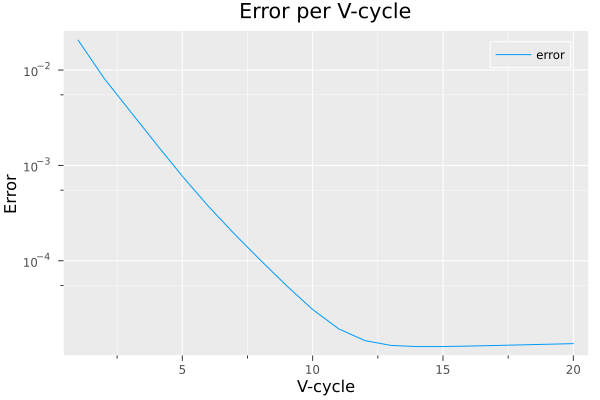

In [12]:
theme(:ggplot2)
plot(errors_shifted, title="Error per V-cycle", label="error", xlabel="V-cycle", ylabel="Error",yscale=:log10)

┌ Info: Saved animation to C:\Users\isido\AppData\Local\Temp\jl_lyL2p4NsTK.gif
└ @ Plots C:\Users\isido\.julia\packages\Plots\sxUvK\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\isido\\AppData\\Local\\Temp\\jl_lyL2p4NsTK.gif")
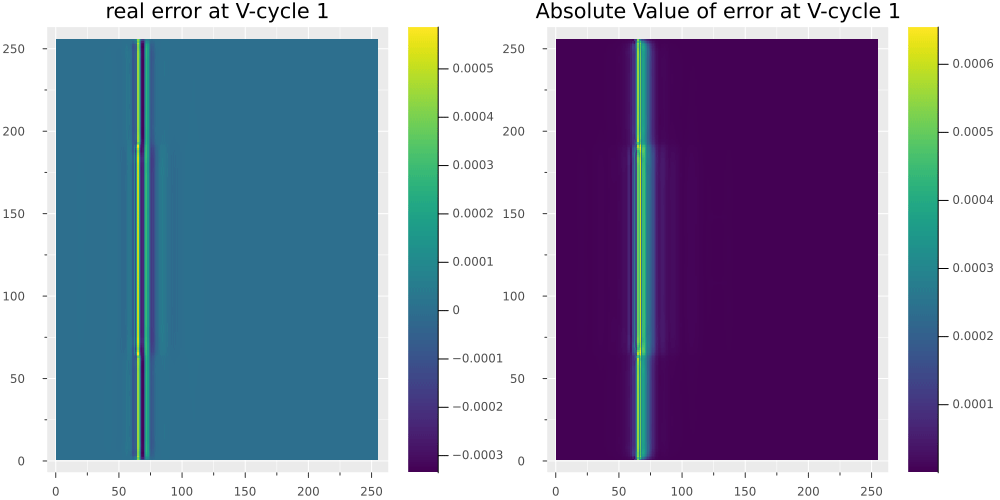

In [14]:
@gif for (i,uu) in enumerate(us) 
z = reshape(uu-sol_shifted, 2n-1, 2n-1)
p1 = heatmap(real(z), color=:viridis, title="real error at V-cycle $i")
p2 = heatmap(abs.(z), color=:viridis, title="Absolute Value of error at V-cycle $i")
plot(p1, p2, layout = (1, 2), size = (1000, 500))
end fps = 1

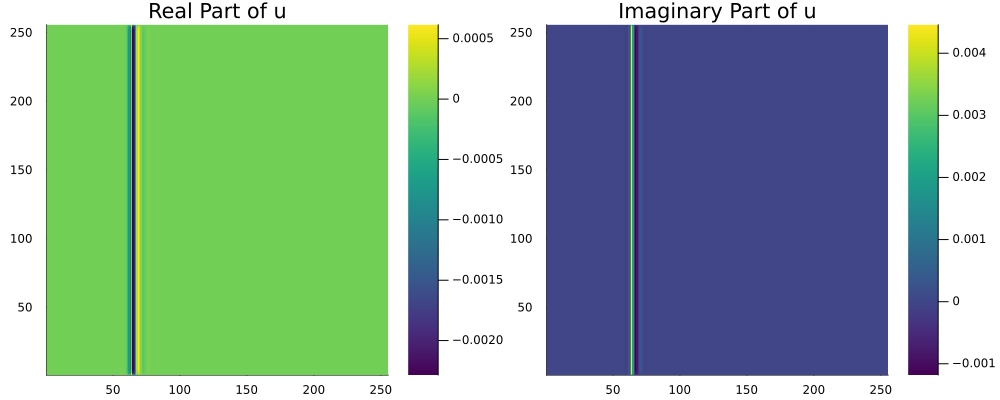

In [17]:
theme(:default)
z = reshape(u_shifted, 2n-1, 2n-1)
p1 = heatmap(real(z), color=:viridis, title="Real Part of u")
p2 = heatmap(imag(z), color=:viridis, title="Imaginary Part of u")

plot(p1, p2, layout = (1, 2), size = (1000, 400))


# GMRES

In [18]:
n = 2^7
grid,m = linspacecs(0,1,n+1,pi/6)
f =zeros(length(grid),length(grid))
f[:,64] .= n
f = vec(f);
complex_shift = (1+im)
σ = -10000 * ones(length(grid),length(grid))
σ[:, 126:130] .= -1000000
σ[union(106:110, 146:150), 126:130] .= -10000
σ_shifted = σ*complex_shift
sigmas = spdiagm(vec(σ))
sigmas_shifted = spdiagm(vec(σ_shifted))
H = helmholtz2D(grid,sigmas);
H_shifted = helmholtz2D(grid,sigmas_shifted);

pre = nonuniform_preconditioner(; grid=grid, H=H_shifted,nu1=1,nu2=1)

myPreconditioner(var"#pres#23"{Vector{ComplexF64}, SparseMatrixCSC{ComplexF64, Int64}, Int64, Int64}(ComplexF64[-0.4921875 - 0.2841645856167689im, -0.484375 - 0.27965403663872496im, -0.4765625 - 0.275143487660681im, -0.46875 - 0.27063293868263705im, -0.4609375 - 0.26612238970459307im, -0.453125 - 0.26161184072654914im, -0.4453125 - 0.25710129174850516im, -0.4375 - 0.25259074277046123im, -0.4296875 - 0.2480801937924173im, -0.421875 - 0.24356964481437335im  …  1.421875 + 0.24356964481437335im, 1.4296875 + 0.2480801937924173im, 1.4375 + 0.25259074277046123im, 1.4453125 + 0.25710129174850516im, 1.453125 + 0.26161184072654914im, 1.4609375 + 0.26612238970459307im, 1.46875 + 0.27063293868263705im, 1.4765625 + 0.275143487660681im, 1.484375 + 0.27965403663872496im, 1.4921875 + 0.2841645856167689im], sparse([1, 2, 256, 1, 2, 3, 257, 2, 3, 4  …  65022, 65023, 65024, 64769, 65023, 65024, 65025, 64770, 65024, 65025], [1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 

In [19]:
S = Krylov.ktypeof(complex(float(f)))
global X = S[]  # Storage for GMRES iterates
gmres_callback(solver) = gmres_callbackX!(X,solver)

gmres_callback (generic function with 1 method)

In [24]:
X = S[]
presol, prestats = gmres(H, complex(float(f)), 
M=pre,
ldiv =false,
itmax = 150 ,
memory=201,
restart =true,
history=true,
callback =gmres_callback);
preres = [norm(H *x-f) for x in X];

In [25]:
X = S[]
nsol, nstats = gmres(H, complex(float(f)), 
M=I,
ldiv =false,
itmax = 150 ,
memory=201,
restart =true,
history=true,
callback =gmres_callback);
nres = [norm(H *x-f) for x in X];

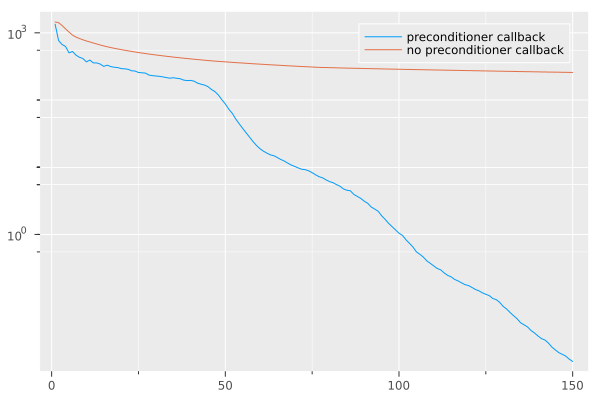

In [28]:
theme(:ggplot2)
plot(preres, yscale =:log10, label="preconditioner callback")
plot!(nres, yscale =:log10, label="no preconditioner callback")

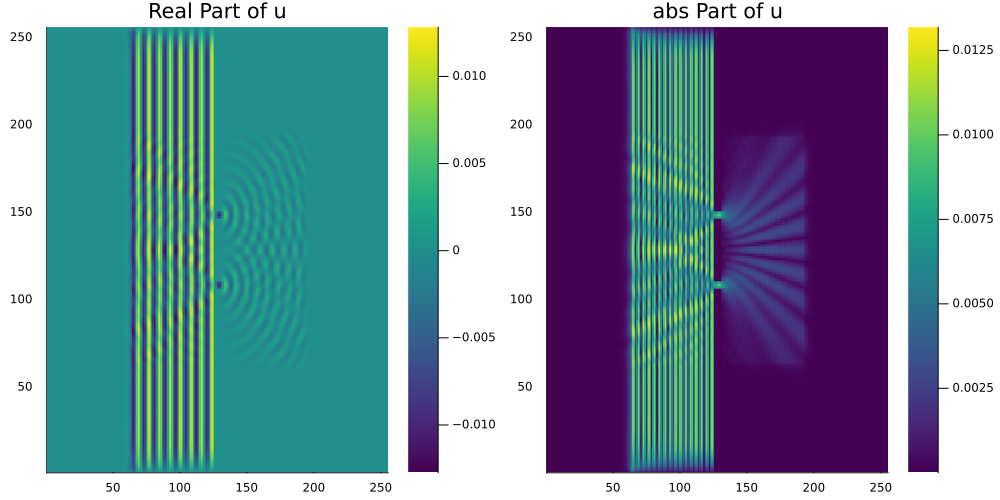

In [29]:
theme(:default)
z = reshape(presol, 2n-1, 2n-1)
p1 = heatmap(real(z), color=:viridis, title="Real Part of u")
p2 = heatmap(abs.(z), color=:viridis, title="abs Part of u")

plot(p1, p2, layout = (1, 2), size = (1000, 500))